In [88]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import data_functions as dat_func, visualizations as vis
import yfinance as yf
from datetime import datetime
import QuantLib as ql
from scipy.optimize import minimize
import warnings

import patsy
import statsmodels.api as sm

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

# Get stock data

In [89]:
start_date,end_date="2023-04-19",'2024-04-19'
start_date,end_date=pd.to_datetime(start_date),pd.to_datetime(end_date)
trade_dates=dat_func.get_trading_days(start_date,end_date)

tickers = ['XOM','FI','ATKR','VICI','STLD','GOOG','BN','BKNG','SBUX','NKE']
ex_stock='XOM'
stock_df=dat_func.get_price_df(tickers,start_date,end_date)

[*********************100%%**********************]  10 of 10 completed


In [90]:
# Option Pricing
def price_option(S0,vol,strike,risk_free_rate,expire,call=True):
        if call:
            option = ql.EuropeanOption( ql.PlainVanillaPayoff(ql.Option.Call, strike),
                         ql.EuropeanExercise(expire))
        else:
            option = ql.EuropeanOption( ql.PlainVanillaPayoff(ql.Option.Put, strike),
                         ql.EuropeanExercise(expire))
        u = ql.SimpleQuote(S0)      # set todays value of the underlying
        r = ql.SimpleQuote(risk_free_rate)       # set risk-free rate 
        sigma = ql.SimpleQuote(vol)   # set volatility
        riskFreeCurve = ql.FlatForward(0, ql.TARGET(), ql.QuoteHandle(r), ql.Actual360())
        volatility = ql.BlackConstantVol(0, ql.TARGET(), ql.QuoteHandle(sigma), ql.Actual360())
        # The Model
        process = ql.BlackScholesProcess( ql.QuoteHandle(u), 
                                       ql.YieldTermStructureHandle(riskFreeCurve),
                                       ql.BlackVolTermStructureHandle(volatility))
        engine = ql.AnalyticEuropeanEngine(process)
        # The Result
        option.setPricingEngine(engine)
        return option.NPV()

In [105]:
# Get df of option prices
def create_options(stock_df, stocks, strike_pcts,risk_free_rate, today,expire):
    dfs_to_concat = []
    ql.Settings.instance().evaluationDate = today
    for stock in stocks:
        S0 = stock_df[stock][-1]
        vol=returns_df.std()[ex_stock]*np.sqrt(252)
        
        strikes = [pct * S0 for pct in strike_pcts]
        #strikes = [S0*0.9, S0, S0*1.1]
        
        price_at_strike = []
        
        for strike in strikes:
            call = price_option(S0,vol,strike,risk_free_rate,expire,call=True)
            price_at_strike.append(call)
            put = price_option(S0,vol,strike,risk_free_rate,expire,call=False)
            price_at_strike.append(put)
        
        df_row = pd.DataFrame({
                'Ticker': [stock],
                'call_90_pct': [price_at_strike[0]],
                'call_atm': [price_at_strike[2]],
                'call_110_pct': [price_at_strike[4]],
                'put_90_pct': [price_at_strike[1]],
                'put_atm': [price_at_strike[3]],
                'put_110_pct': [price_at_strike[5]],
            })
            
        dfs_to_concat.append(df_row)
    
    output = pd.concat(dfs_to_concat, ignore_index=True)  
    return output

## Get option prices for tickers

In [106]:
tickers = ['XOM','FI','ATKR','VICI','STLD','GOOG','BN','BKNG','SBUX','NKE']
fred,poly=dat_func.connect_apis()
risk_free_rate=fred.get_series('GS10').iloc[-1]/100
today = ql.Date(19, 4, 2024)
expire = ql.Date(19, 4, 2025)
strike_pcts = [0.9, 1, 1.1]
create_options(stock_df, tickers, strike_pcts,risk_free_rate, today,expire)

,Ticker,call_90_pct,call_atm,call_110_pct,put_90_pct,put_atm,put_110_pct
0,XOM,19.815407,12.696876,7.623098,3.506120,7.744334,14.027301
1,FI,24.561944,15.738257,9.449118,4.345968,9.599394,17.387369
2,ATKR,28.619654,18.338266,11.010141,5.063935,11.185244,20.259816
3,VICI,4.601080,2.948178,1.770061,0.814111,1.798212,3.257099
4,STLD,22.749601,14.576984,8.751899,4.025293,8.891087,16.104413
5,GOOG,26.325804,16.868464,10.127684,4.658063,10.288752,18.636003
6,BN,6.450207,4.133020,2.481431,1.141294,2.520895,4.566093
7,BKNG,573.486511,367.465942,220.623473,101.472168,224.132216,405.970363
8,SBUX,14.570645,9.336254,5.605409,2.578116,5.694556,10.314541
9,NKE,16.006810,10.256488,6.157909,2.832230,6.255843,11.331200


## Get Portfolio Weights

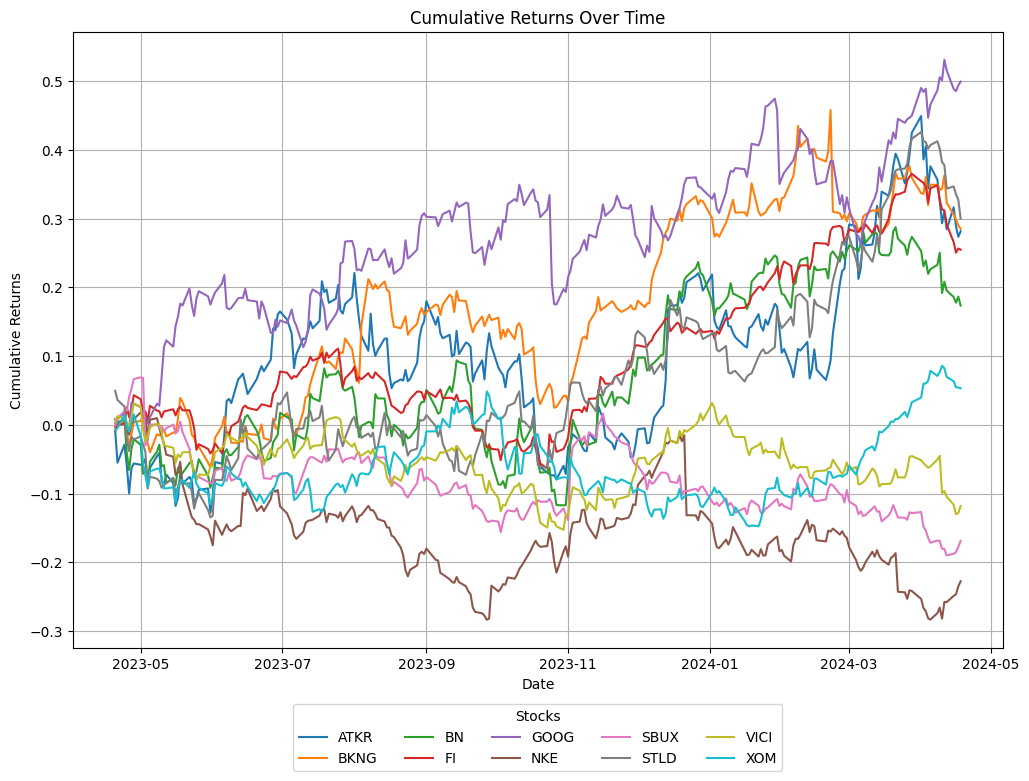

Initial Port Returns: 0.23439845083241406
Initial Port Volatility: 0.08022396612848882
Initial Port Sharpe: 2.3970199943047414
Optimal Weights: {'ATKR': 0.01, 'BKNG': 0.069, 'BN': 0.01, 'FI': 0.293, 'GOOG': 0.144, 'NKE': -0.111, 'SBUX': -0.143, 'STLD': 0.045, 'VICI': -0.15, 'XOM': 0.024}


In [93]:
returns_df=dat_func.get_log_returns(stock_df)
vis.plot_cumulative_returns(returns_df)
init_weights,init_ret,init_std=dat_func.get_init_port(returns_df,risk_free_rate,leverage_limit=1)
init_weights=init_weights.round(3)
weight_dict = dict(zip(returns_df.columns,init_weights))
print('Initial Port Returns:',init_ret)
print('Initial Port Volatility:',init_std)
print('Initial Port Sharpe:',(init_ret-risk_free_rate)/init_std)
print('Optimal Weights:',dict(zip(returns_df.columns,init_weights)))

#

In [97]:
gpc_gbm=dat_func.simulate_gbm(stock_df['XOM'][-1],returns_df.mean()[ex_stock]*252,returns_df.std()[ex_stock]*np.sqrt(252),1,N=100)
sim_min = np.min(gpc_gbm[:,-1])

S0 = stock_df['XOM'][-1]
max_loss = round(sim_min - S0)

loss = np.linspace(0,max_loss,abs(max_loss)+1)  # max loss to 0 by 1
stock_price = np.linspace(S0,sim_min,abs(max_loss)+1)  # stock prices for same loss
portfolio_value = pd.DataFrame({'stock':stock_price, 'loss':loss*-1})

In [98]:
# Add option values by stock price/loss
portfolio_value['put_atm'] = np.maximum(S0 - portfolio_value['stock'],0)
portfolio_value['put_90_pct'] = np.maximum(S0 - portfolio_value['stock']*0.9,0)
portfolio_value['put_110_pct'] = np.maximum(S0 - portfolio_value['stock']*1.1,0)
portfolio_value['call_atm'] = np.maximum(portfolio_value['stock']-S0,0)
portfolio_value['call_90_pct'] = np.maximum(portfolio_value['stock']*0.9 - S0,0)
portfolio_value['call_110_pct'] = np.maximum(portfolio_value['stock']*1.1 - S0,0)
portfolio_value

,stock,loss,put_atm,put_90_pct,put_110_pct,call_atm,call_90_pct,call_110_pct
0,118.519997,-0.0,0.000000,11.852000,0.000000,0.0,0.0,11.852000
1,117.530333,1.0,0.989664,12.742697,0.000000,0.0,0.0,10.763370
2,116.540669,2.0,1.979327,13.633394,0.000000,0.0,0.0,9.674740
3,115.551006,3.0,2.968991,14.524092,0.000000,0.0,0.0,8.586109
4,114.561342,4.0,3.958655,15.414789,0.000000,0.0,0.0,7.497479
5,113.571678,5.0,4.948318,16.305486,0.000000,0.0,0.0,6.408849
6,112.582014,6.0,5.937982,17.196184,0.000000,0.0,0.0,5.320219
7,111.592351,7.0,6.927646,18.086881,0.000000,0.0,0.0,4.231589
8,110.602687,8.0,7.917310,18.977578,0.000000,0.0,0.0,3.142959
9,109.613023,9.0,8.906973,19.868276,0.000000,0.0,0.0,2.054329


In [100]:
y, X = patsy.dmatrices('loss ~ put_atm + put_90_pct + put_110_pct + call_atm + call_90_pct + call_110_pct', portfolio_value)
linear_model = sm.OLS(y, X)
results = linear_model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   loss   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.170e+31
Date:                Thu, 25 Apr 2024   Prob (F-statistic):               0.00
Time:                        16:58:34   Log-Likelihood:                 1404.8
No. Observations:                  46   AIC:                            -2804.
Df Residuals:                      43   BIC:                            -2798.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.0085   2.12e-17     -4e+14   

In [ ]:
def hedge_downside(stock_df, stocks, weights, strike_pcts):
    for stock in stocks:
        long = weight_dict[stock] >0.0  # If we are long the stock
        S0 = stock_df[stock][-1]
        
        gpc_gbm=dat_func.simulate_gbm(stock_df[stock][-1],returns_df.mean()[ex_stock]*252,returns_df.std()[ex_stock]*np.sqrt(252),1,N=100)
        
        if long:
            sim_min = np.min(gpc_gbm[:,-1])  # Get minimum value of stock from sim
            max_loss = round(sim_min - S0)
            loss = np.linspace(0,max_loss,abs(max_loss)+1)  # max loss to 0 by 1
            stock_price = np.linspace(S0,sim_min,abs(max_loss)+1)  # stock prices for same loss
            portfolio_value = pd.DataFrame({'stock':stock_price, 'loss':loss*-1})
        else:
            sim_max = np.max(gpc_gbm[:,-1])  # Get minimum value of stock from sim
            max_loss = round(S0 - sim_max)
            loss = np.linspace(0,max_loss,abs(max_loss)+1)  # max loss to 0 by 1
            stock_price = np.linspace(S0,sim_max,abs(max_loss)+1)  # stock prices for same loss
            portfolio_value = pd.DataFrame({'stock':stock_price, 'loss':loss*-1})
        
        
        

In [110]:
portfolio_value

,stock,loss,put_atm,put_90_pct,put_110_pct,call_atm,call_90_pct,call_110_pct
0,118.519997,-0.0,0.000000,11.852000,0.000000,0.0,0.0,11.852000
1,117.530333,1.0,0.989664,12.742697,0.000000,0.0,0.0,10.763370
2,116.540669,2.0,1.979327,13.633394,0.000000,0.0,0.0,9.674740
3,115.551006,3.0,2.968991,14.524092,0.000000,0.0,0.0,8.586109
4,114.561342,4.0,3.958655,15.414789,0.000000,0.0,0.0,7.497479
5,113.571678,5.0,4.948318,16.305486,0.000000,0.0,0.0,6.408849
6,112.582014,6.0,5.937982,17.196184,0.000000,0.0,0.0,5.320219
7,111.592351,7.0,6.927646,18.086881,0.000000,0.0,0.0,4.231589
8,110.602687,8.0,7.917310,18.977578,0.000000,0.0,0.0,3.142959
9,109.613023,9.0,8.906973,19.868276,0.000000,0.0,0.0,2.054329


In [112]:
long = weight_dict['NKE'] >0.0  # If we are long the stock
S0 = stock_df['NKE'][-1]

gpc_gbm=dat_func.simulate_gbm(stock_df['NKE'][-1],returns_df.mean()[ex_stock]*252,returns_df.std()[ex_stock]*np.sqrt(252),1,N=100)

if long:
    sim_min = np.min(gpc_gbm[:,-1])  # Get minimum value of stock from sim
    max_loss = round(sim_min - S0)
    loss = np.linspace(0,max_loss,abs(max_loss)+1)  # max loss to 0 by 1
    stock_price = np.linspace(S0,sim_min,abs(max_loss)+1)  # stock prices for same loss
    portfolio_value = pd.DataFrame({'stock':stock_price, 'loss':loss*-1})
else:
    sim_max = np.max(gpc_gbm[:,-1])  # Get minimum value of stock from sim
    max_loss = round(S0 - sim_max)
    loss = np.linspace(0,max_loss,abs(max_loss)+1)  # max loss to 0 by 1
    stock_price = np.linspace(S0,sim_max,abs(max_loss)+1)  # stock prices for same loss
    portfolio_value = pd.DataFrame({'stock':stock_price, 'loss':loss*-1})

In [118]:
np.linspace(S0,round(sim_max),abs(max_loss))

array([ 95.73999786,  96.75749789,  97.77499792,  98.79249795,
        99.80999798, 100.82749801, 101.84499804, 102.86249807,
       103.8799981 , 104.89749813, 105.91499816, 106.93249819,
       107.94999822, 108.96749825, 109.98499828, 111.00249831,
       112.01999834, 113.03749837, 114.0549984 , 115.07249843,
       116.08999846, 117.10749849, 118.12499852, 119.14249855,
       120.15999858, 121.17749861, 122.19499864, 123.21249866,
       124.22999869, 125.24749872, 126.26499875, 127.28249878,
       128.29999881, 129.31749884, 130.33499887, 131.3524989 ,
       132.36999893, 133.38749896, 134.40499899, 135.42249902,
       136.43999905, 137.45749908, 138.47499911, 139.49249914,
       140.50999917, 141.5274992 , 142.54499923, 143.56249926,
       144.57999929, 145.59749932, 146.61499935, 147.63249938,
       148.64999941, 149.66749944, 150.68499947, 151.7024995 ,
       152.71999953, 153.73749955, 154.75499958, 155.77249961,
       156.78999964, 157.80749967, 158.8249997 , 159.84